In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

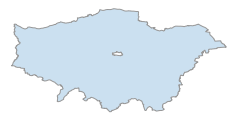

{'init': 'epsg:4326'}


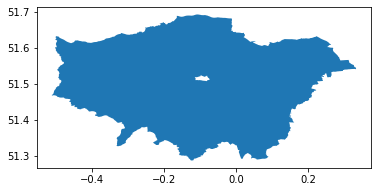

time: 1.82 s


In [2]:
city = ox.gdf_from_place('London, UK', which_result=2)
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

In [15]:
data = pd.read_csv('data/Airbnb_London.csv', header=0)
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11551,Arty and Bright London Apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,184,2019-07-10,1.59,2,344
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,16,2019-06-10,0.14,3,353
2,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,30,87,2019-08-27,0.73,1,114
3,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52098,-0.14002,Entire home/apt,300,3,41,2019-06-19,0.40,15,265
4,24328,Battersea bedroom & office w parking shared ga...,41759,Joe,NaN,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,93,2019-06-08,0.86,1,346


time: 321 ms


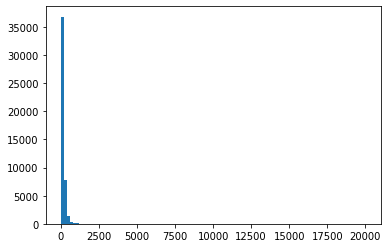

time: 1.3 s


In [17]:
data = data[data.room_type=='Entire home/apt']
plt.hist(data.price, bins=100)
plt.show()

In [19]:
len(data[data.price>500])

1317

time: 13 ms


In [14]:
data = pd.read_csv('data/Airbnb_London.csv', header=0)
data = data[data.room_type=='Entire home/apt']
data.dropna()
data = data[['id','latitude', 'longitude', 'price']]
print(len(data))
data.head()

47116


,id,latitude,longitude,price
0,11551,51.46225,-0.11732,88
2,15400,51.48796,-0.16898,100
3,17402,51.52098,-0.14002,300
4,24328,51.47298,-0.16376,175
5,25023,51.44687,-0.21874,65


time: 477 ms


In [4]:
data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data max index: 15879
number of NA prices: 0
time: 3 ms


In [5]:
geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])
polyframe.tail()

,geometry,center_lon,center_lat
10729,POLYGON ((-0.3172432074423089 51.4959948032922...,-0.314997,51.493769
10730,POLYGON ((-0.3127517680806068 51.5093502098856...,-0.310506,51.507124
10731,POLYGON ((-0.3127517680806068 51.5048984076878...,-0.310506,51.502673
10732,POLYGON ((-0.3127517680806068 51.5004466054900...,-0.310506,51.498221
10733,POLYGON ((-0.3127517680806068 51.4959948032922...,-0.310506,51.493769


time: 22.3 s


In [6]:
gdf.head()

,id,latitude,longitude,price,geometry
0,25428,52.37297,4.88339,125,POINT (4.88339 52.37297)
1,31080,52.35132,4.84838,219,POINT (4.848380000000001 52.35132)
2,43109,52.37537,4.88932,210,POINT (4.88932 52.37537)
3,43980,52.35746,4.86124,100,POINT (4.86124 52.35746)
4,44391,52.37017,4.91438,240,POINT (4.91438 52.37017)


time: 18 ms


In [13]:
gdf.crs

{'init': 'epsg:4326'}

time: 2 ms


In [7]:
pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

pointinpoly length: 0
time: 1.85 s


In [8]:
#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)

time: 4 ms


In [11]:
pointInPoly.head()

,geometry,center_lon,center_lat,index_right,id,latitude,longitude,price,index


time: 8 ms


In [9]:
present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

time: 4 ms


In [10]:
gdf_dropped.head()

,id,latitude,longitude,price,geometry


time: 12 ms
